# Notebook to plot various types of graphs

In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams

# # For Japanese
# import matplotlib.font_manager as fm # noqa
# rcParams["font.family"] = "Yu Mincho"
# rcParams["font.family"] = "Yu Gothic"
# print(set([f.name for f in fm.fontManager.ttflist]))

In [2]:
class PlotStyler():
    def __init__(self, n, cmap="Set1", change_linestyle=True):
        assert cmap in ["hsv", "Set1", "Accent"]
        self.cmap = cmap
        self.i = -1
        self.n = n
        self.cm = plt.get_cmap(cmap)
        if change_linestyle:
            self.linestyles = [
                "solid", "dotted", "dashed", "dashdot", 
                (0, (3, 1, 1, 1, 1, 1)), (0, (5, 1)), (0, (3, 5, 1, 5, 1, 5))
            ]
        else:
            self.linestyles = ["solid"]

    def get(self):
        self.i += 1
        ls = self.linestyles[self.i % len(self.linestyles)]
        if self.cmap in ["hsv", "Accent"]:
            c = self.cm(self.i/self.n)
        else:
            c = self.cm(self.i)
        return c, ls

### Data collection

In [3]:
catalog_filename = os.path.join("log", "catalog.json")
with open(catalog_filename, "r") as f:
    catalog = json.load(f)

raw_data = {}
for simname, loglist in catalog.items():
    if "comment" in simname:
        continue
    l = []
    for log in loglist:
        with open(os.path.join("log", log, "history.json"), "r") as f:
            history = json.load(f)
            l.append(history)
    raw_data[simname] = l

### Data formatting

In [4]:
data = {}
compare_data = {}
for simname, raw_data_list in raw_data.items():
    l = []
    for i in range(len(raw_data_list)):
        if i > 4:
            break
        d = raw_data_list[i]
        generations = np.array([h["generation"] for h in d])
        elapseds = np.array([h["elapsed"] for h in d])
        best_species_eval_rewards = np.array([h["best_reward"] for h in d])
        best_rewards = np.array([h["current_best_reward"] for h in d])
        mean_rewards = np.array([h["current_mean_reward"] for h in d])
        min_rewards = np.array([h["current_min_reward"] for h in d])
        species_mean_rewards = np.array([h["current_mean_rewards"] for h in d])
        species_eval_rewards = np.array([h["current_eval_rewards"] for h in d])
        success_rates = np.mean(np.array([h["success_rate"] for h in d]), axis=2)
        num_limbs = np.array([h["num_limbs"] for h in d])
        l.append({
            "generations": generations,
            "elapseds": elapseds,
            "best_species_eval_rewards": best_species_eval_rewards,
            "best_rewards": best_rewards,
            "mean_rewards": mean_rewards,
            "min_rewards": min_rewards,
            "species_mean_rewards": species_mean_rewards,
            "species_eval_rewards": species_eval_rewards,
            "success_rates": success_rates,
            "num_limbs": num_limbs
        })
    data[simname] = l

    # Create compare_data
    simrange = 10000
    for ll in l:
        simrange = min(simrange, len(ll["best_species_eval_rewards"]))
    x = np.array([ll["best_species_eval_rewards"][:simrange] for ll in l])
    compare_mean = np.mean(x, axis=0)
    compare_std = np.std(x, axis=0)
    compare_data[simname] = {
        "generations": np.array(range(len(compare_mean))),
        "compare_mean": compare_mean,
        "compare_std": compare_std
    }

### Plot method declaration 

In [5]:
def plot(d, xlim=None, ylim=None, title=None, plot_limbs=False, replace_reward_by_success_rate=False):
    generations = d["generations"]
    best_rewards = d["best_rewards"]
    mean_rewards = d["mean_rewards"]
    min_rewards = d["min_rewards"]
    species_mean_rewards = d["species_mean_rewards"]
    species_eval_rewards = d["species_eval_rewards"]
    num_limbs = d["num_limbs"]
    num_species = len(species_eval_rewards[0])
    if replace_reward_by_success_rate:
        species_eval_rewards = d["success_rates"]
        ylim = (0, 1)

    plt.rcParams["font.size"] = 30
    ps = PlotStyler(16)
    fig=plt.figure(figsize=(16, 10), dpi= 80, facecolor="w", edgecolor="k")
    if title is not None:
        fig.suptitle(title)
    ax1 = fig.add_subplot(111)

    # Decide the color and line style first
    styles = []
    for i in range(num_species):
        styles.append(ps.get())

    if plot_limbs:
        # rigid parts graph
        c, ls = ps.get()
        ax2 = ax1.twinx()
        ax2.plot(generations, num_limbs[:, 0], color=c, linestyle = ls, label="number of rigid parts")

    # reward graph
    for i in range(num_species):
        c, ls = styles[i]
        label = f"reward in worker {i+1}"
        if num_species == 1:
            label = "reward"
        ax1.plot(generations, species_mean_rewards[:, i], color=c, alpha=0.2)
        ax1.plot(generations, species_eval_rewards[:, i], color=c, linestyle = ls, label=label)

    h, l = ax1.get_legend_handles_labels()
    if plot_limbs:
        h2, l2 = ax2.get_legend_handles_labels()
        h += h2
        l += l2
        ax2.set_ylabel("number of rigid parts")
        
    plt.rcParams["font.size"] = 24
    if "ax2" in locals():
        # To eliminate overlap with ax2 graph
        ax2.legend(h, l, loc="upper left")
    else:
        ax1.legend(h, l, loc="upper left")
    ax1.set_xlabel("generation")
    ax1.set_ylabel("reward")

    if ylim is not None:
        ax1.set_ylim(ylim)
    if xlim is not None:
        ax1.set_xlim(xlim)
        if plot_limbs:
            ax2.set_xlim(xlim)

### Plot walking task

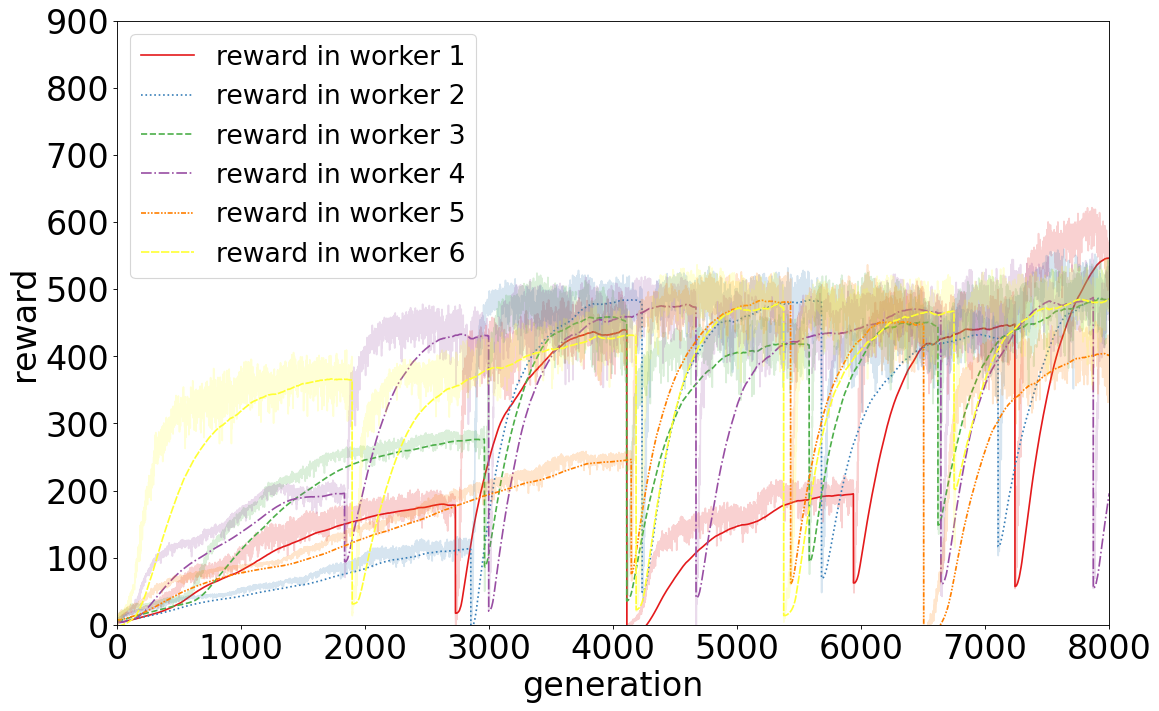

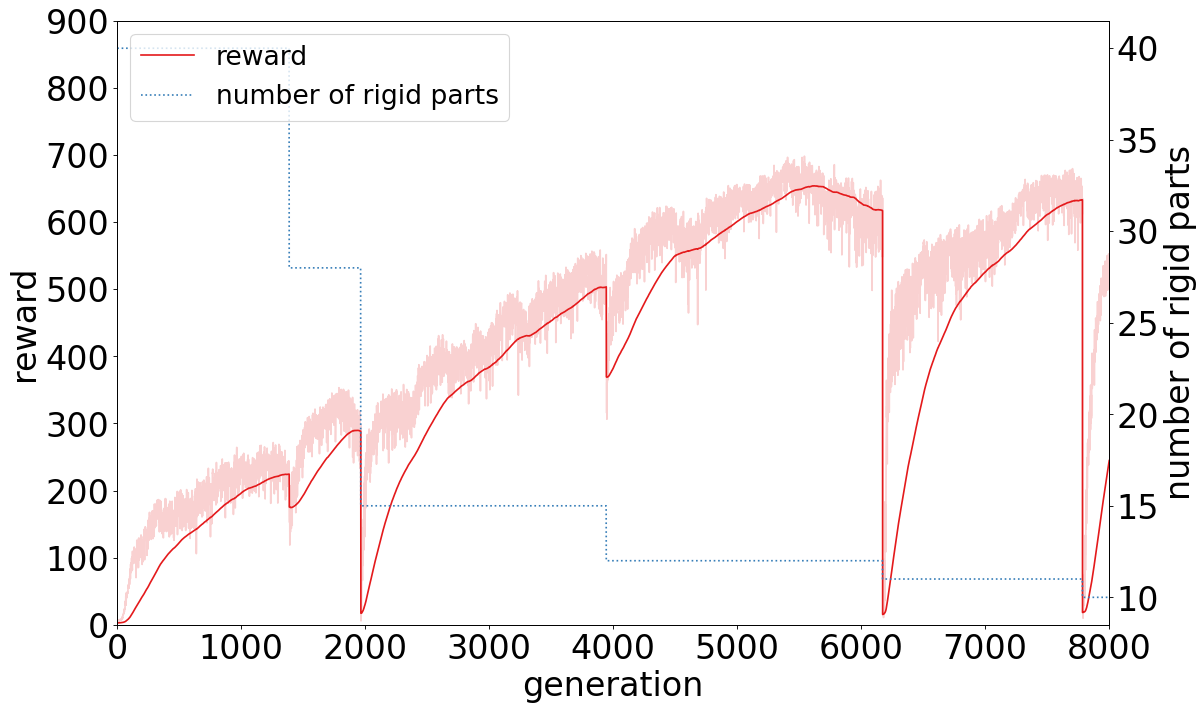

In [6]:
plot(data["icm_rein_ppo_starfish6"][1], xlim=(0, 8000), ylim=(0, 900))
# plot(data["icm_rein_ppo_starfish6_p1"][0], xlim=(0, 8000), ylim=(0, 900))
plot(data["mdm_rein_ppo_ant40"][1], xlim=(0, 8000), ylim=(0, 900), plot_limbs=True)
# plot(data["rand_rein_ppo_starfish6"][0], xlim=(0, 10000), ylim=(0, 900))
# plot(data["fix_rein_ppo_starfish6"][0], xlim=(0, 10000), ylim=(0, 900))
# plot(data["fix_fix_ppo_starfish6"][0], xlim=(0, 10000), ylim=(0, 900))

### Plot manipulation task

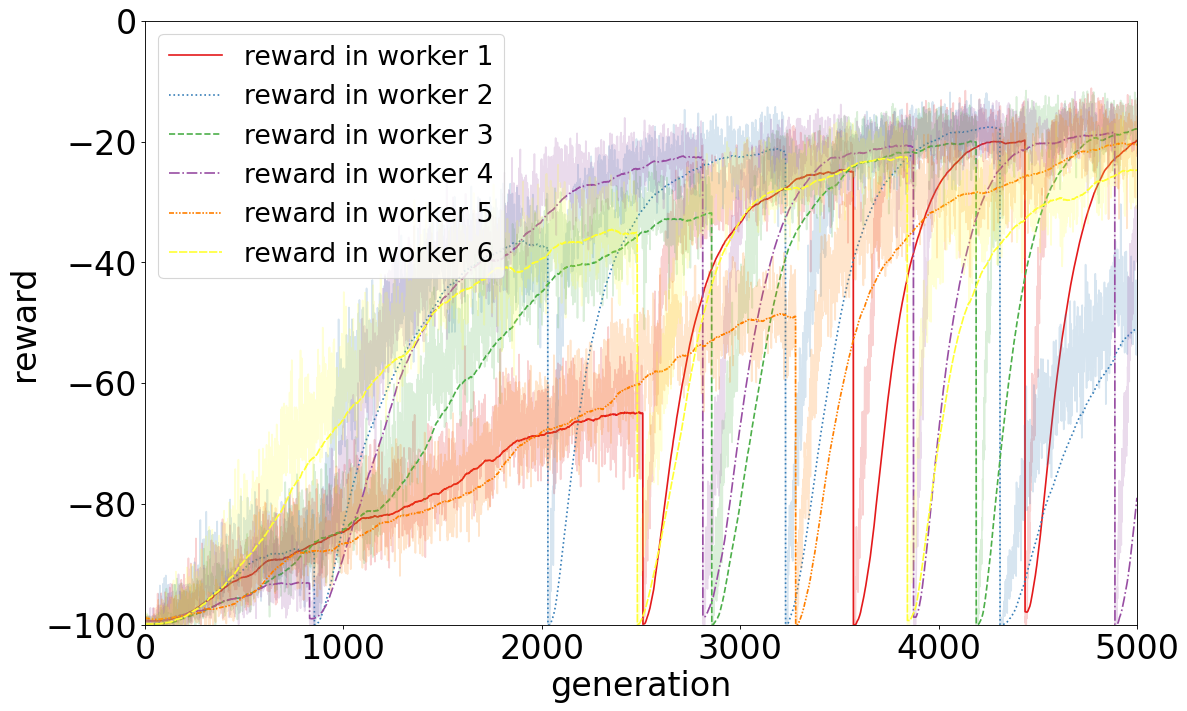

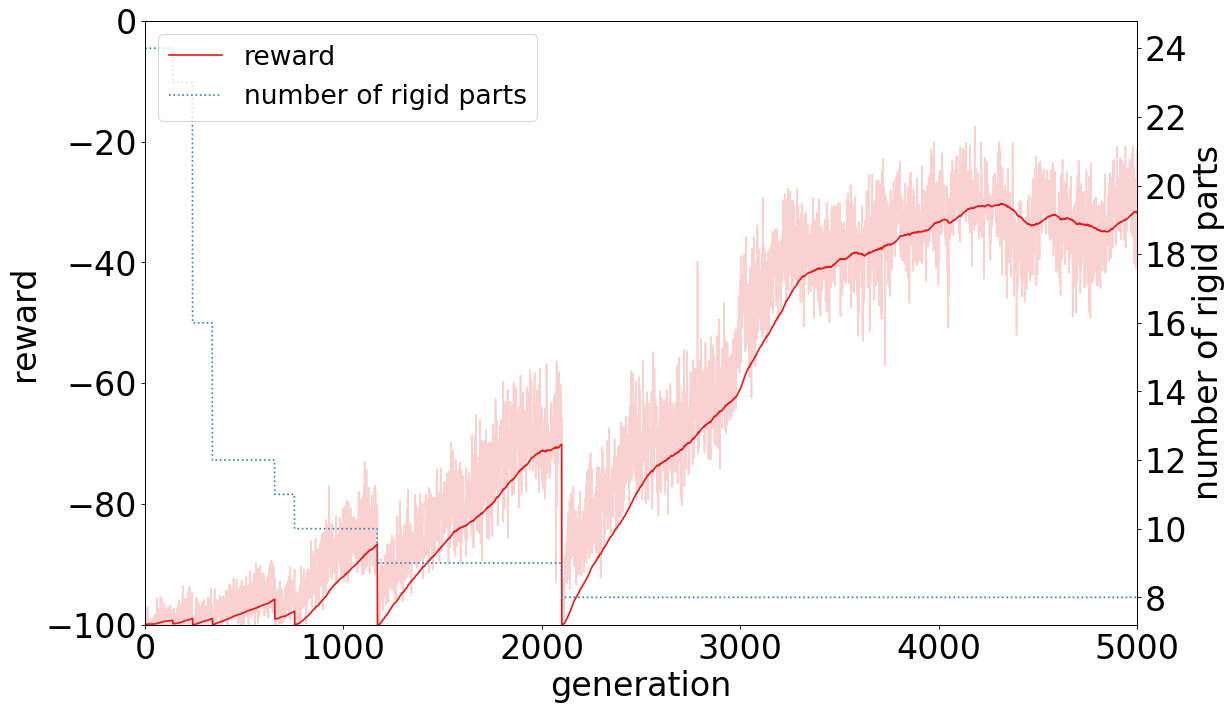

In [7]:
plot(data["icm_rein_sac_hand5"][1], xlim=(0, 5000), ylim=(-100, 0))
# plot(data["icm_rein_sac_hand5_p1"][0], xlim=(0, 5000), ylim=(-100, 0))
plot(data["mdm_rein_sac_hand24"][1], xlim=(0, 5000), ylim=(-100, 0), plot_limbs=True)
# plot(data["rand_rein_sac_hand5"][0], xlim=(0, 5000), ylim=(-100, 0))
# plot(data["fix_rein_sac_hand5"][0], xlim=(0, 5000), ylim=(-100, 0))
# plot(data["fix_fix_sac_hand5"][0], xlim=(0, 5000), ylim=(-100, 0))

### Plot methods comparison

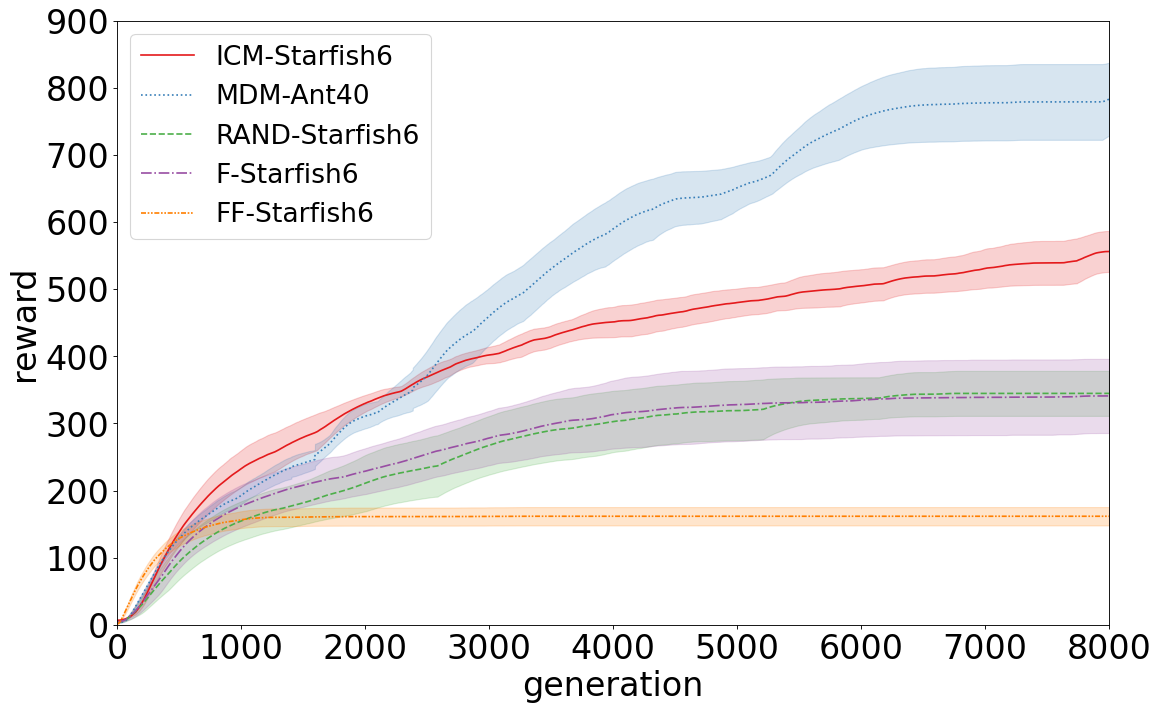

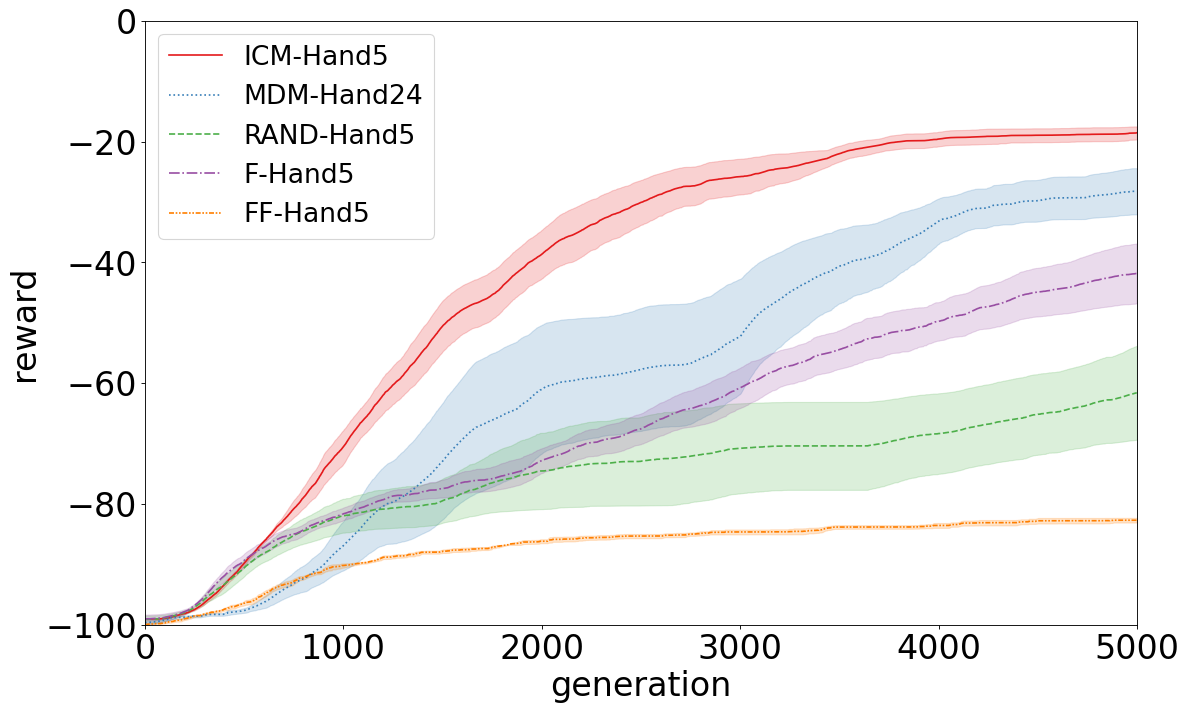

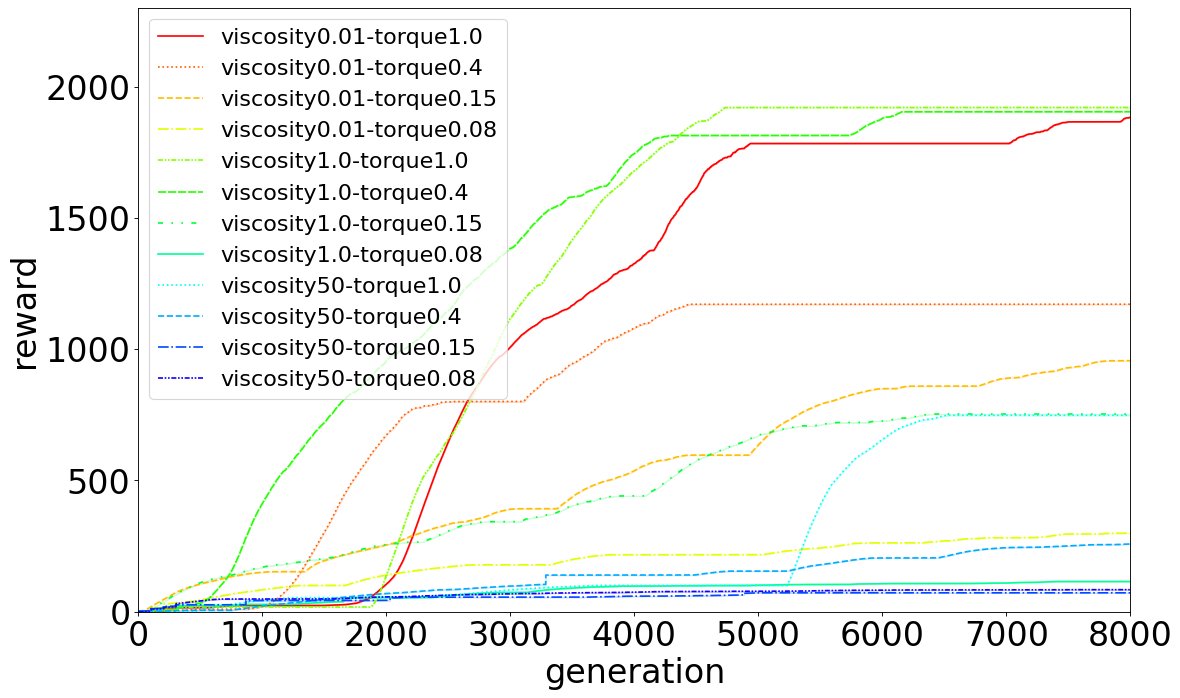

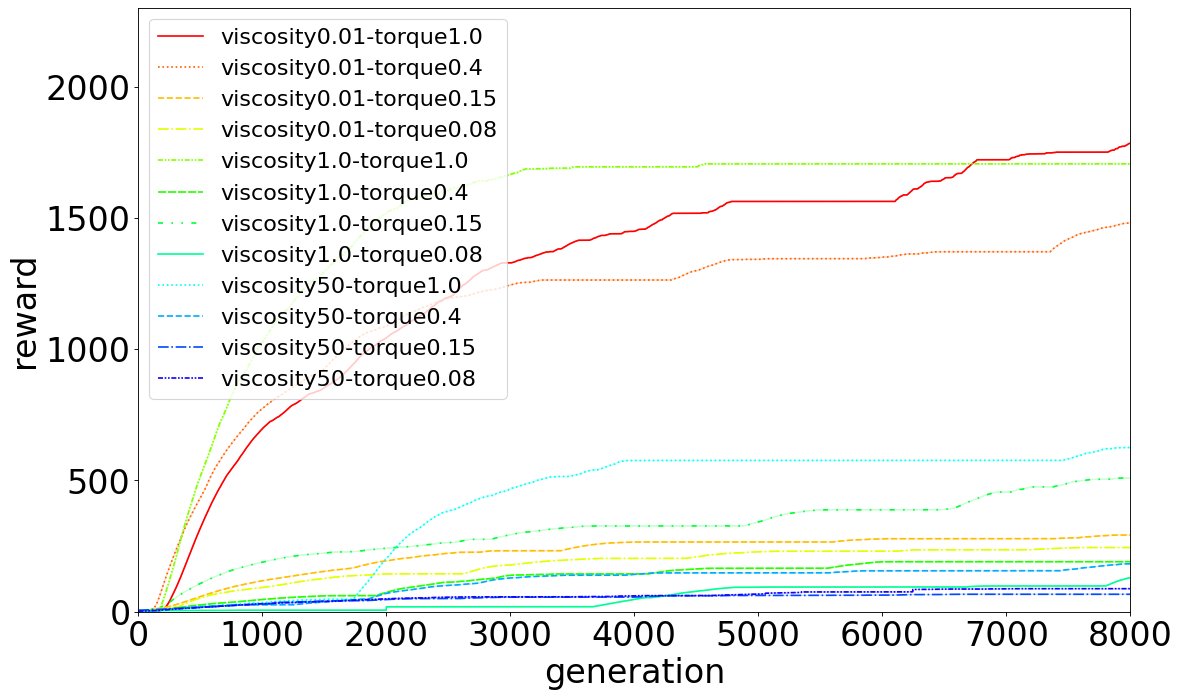

In [8]:
def plot_compare(sim_list, xlim=None, ylim=None, title=None, cmap="Set1", label_font_size=24, std_rate=1.0):
    plt.rcParams["font.size"] = 30
    ps = PlotStyler(16, cmap=cmap)
    fig=plt.figure(figsize=(16, 10), dpi= 80, facecolor="w", edgecolor="k")
    if title is not None:
        fig.suptitle(title)
    ax1 = fig.add_subplot(111)
    
    for [simname, label] in sim_list:
        c, ls = ps.get()
        generations = compare_data[simname]["generations"]
        mean_rewards = compare_data[simname]["compare_mean"]
        std_rewards = compare_data[simname]["compare_std"]
        if std_rate > 0:
            ax1.fill_between(generations, mean_rewards-std_rate*std_rewards, mean_rewards+std_rate*std_rewards, color=c, alpha=0.2)
        ax1.plot(generations, mean_rewards, color=c, linestyle=ls, label=label)

    h, l = ax1.get_legend_handles_labels()
    plt.rcParams["font.size"] = label_font_size
    ax1.legend(h, l, loc="upper left")
    ax1.set_xlabel("generation")
    ax1.set_ylabel("reward")

    if ylim is not None:
        ax1.set_ylim(ylim)
    if xlim is not None:
        ax1.set_xlim(xlim)
    
    # plt.savefig("plot.svg", format="svg")
    # plt.savefig("plot.png", format="png")
    
    # # check for gray scale
    # import cv2
    # image = cv2.imread("plot.png")
    # cv2.imwrite("gray_plot.png", cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))


plot_compare([
    ["icm_rein_ppo_starfish6", "ICM-Starfish6"],
    ["mdm_rein_ppo_ant40", "MDM-Ant40"],
    ["rand_rein_ppo_starfish6", "RAND-Starfish6"],
    ["fix_rein_ppo_starfish6", "F-Starfish6"],
    ["fix_fix_ppo_starfish6", "FF-Starfish6"],
], xlim=(0, 8000), ylim=(0, 900), std_rate=0.5)
plot_compare([
    ["icm_rein_sac_hand5", "ICM-Hand5"],
    ["mdm_rein_sac_hand24", "MDM-Hand24"],
    ["rand_rein_sac_hand5", "RAND-Hand5"],
    ["fix_rein_sac_hand5", "F-Hand5"],
    ["fix_fix_sac_hand5", "FF-Hand5"],
], xlim=(0, 5000), ylim=(-100, 0), std_rate=0.5)
plot_compare([
    ["ewalker_mdm_001_10" , "viscosity0.01-torque1.0"],
    ["ewalker_mdm_001_04" , "viscosity0.01-torque0.4"],
    ["ewalker_mdm_001_015", "viscosity0.01-torque0.15"],
    ["ewalker_mdm_001_008", "viscosity0.01-torque0.08"],
    ["ewalker_mdm_1_10"   , "viscosity1.0-torque1.0"],
    ["ewalker_mdm_1_04"   , "viscosity1.0-torque0.4"],
    ["ewalker_mdm_1_015"  , "viscosity1.0-torque0.15"],
    ["ewalker_mdm_1_008"  , "viscosity1.0-torque0.08"],
    ["ewalker_mdm_50_10"  , "viscosity50-torque1.0"],
    ["ewalker_mdm_50_04"  , "viscosity50-torque0.4"],
    ["ewalker_mdm_50_015" , "viscosity50-torque0.15"],
    ["ewalker_mdm_50_008" , "viscosity50-torque0.08"],
], xlim=(0, 8000), ylim=(0, 2300), cmap="hsv", label_font_size=20)
plot_compare([
    ["ewalker_icm_001_10" , "viscosity0.01-torque1.0"],
    ["ewalker_icm_001_04" , "viscosity0.01-torque0.4"],
    ["ewalker_icm_001_015", "viscosity0.01-torque0.15"],
    ["ewalker_icm_001_008", "viscosity0.01-torque0.08"],
    ["ewalker_icm_1_10"   , "viscosity1.0-torque1.0"],
    ["ewalker_icm_1_04"   , "viscosity1.0-torque0.4"],
    ["ewalker_icm_1_015"  , "viscosity1.0-torque0.15"],
    ["ewalker_icm_1_008"  , "viscosity1.0-torque0.08"],
    ["ewalker_icm_50_10"  , "viscosity50-torque1.0"],
    ["ewalker_icm_50_04"  , "viscosity50-torque0.4"],
    ["ewalker_icm_50_015" , "viscosity50-torque0.15"],
    ["ewalker_icm_50_008" , "viscosity50-torque0.08"],
], xlim=(0, 8000), ylim=(0, 2300), cmap="hsv", label_font_size=20)